In [3]:
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import scipy
import sklearn
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from PIL import *
import matplotlib.image as mpimg
from keras import layers
from keras import models
from keras import callbacks
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler


train_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN1/Images_3mm_extend/"
dirLen= len(train_dir)
test_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN2/Images_3mm_extend/"
fileName='E:/Downloads/9. Lymph_node/9. Lymph_node/HM lymph node annotations1.csv'


df=pd.read_csv(fileName)
malignant_training =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='training cohort')]
print(len(malignant_training))
malignant_testing =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='test cohort')]
print(len(malignant_testing))

benign_training =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='training cohort')]
print(len(benign_training))
benign_testing =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='test cohort')]
print(len(benign_testing))

malignTrainFilesList=[]
malignTestFilesList=[]
benignTestFilesList=[]
benignTrainFilesList=[]

for i in range(len(benign_training)):
    if(benign_training.iloc[i]['nodule_ID']<9):
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_training.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_training.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(benign_testing)):
    if(benign_testing.iloc[i]['nodule_ID']<9):
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_testing.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(malignant_testing)):
    if(malignant_testing.iloc[i]['nodule_ID']<9):
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_testing.iloc[i]['nodule_ID'].astype(str))        

for i in range(len(malignant_training)):
    if(malignant_training.iloc[i]['nodule_ID']<9):
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_training.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_training.iloc[i]['nodule_ID'].astype(str))        





train_malign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in malignTrainFilesList)]
train_benign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in benignTrainFilesList)]
test_malign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in malignTestFilesList)]
test_benign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in benignTestFilesList)]

test_full= [test_dir+"{}".format(i) for i in os.listdir(test_dir) 
            if ((i.split('.')[0] in benignTestFilesList)
                or (i.split('.')[0] in malignTestFilesList))]

train_random= train_malign[:]+train_benign[:]
random.shuffle(train_random)



nrows= 25
ncolumns=25
channels=3

def mat_to_image(mat_image):
    f = loadmat(mat_image,appendmat=True)
    image = np.array(f.get('I_3mm')).astype(np.float64)
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint16)
    im = Image.fromarray(image)
    return im

def read_process_img(images, imgtype):
    X= []
    Y= []

    for i in images:
        im= mat_to_image(i)
        cv_img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

        X.append(cv2.resize(cv_img,(nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        # checking if malign List or the benign List of files has the image .
        if (i[dirLen:].split(".")[0] in malignTrainFilesList and imgtype=='train')or (i[dirLen:].split(".")[0] in malignTestFilesList and imgtype=='test'):
            Y.append(1)
        elif (i[dirLen:].split(".")[0] in benignTrainFilesList and imgtype=='train') or (i[dirLen:].split(".")[0] in benignTestFilesList and imgtype=='test'):
            Y.append(0)
            
        
    return X,Y 

def read_process_img_plain_train(images, imgtype):
    X= []
    Y= []

    for i in images:
        im= mat_to_image(i)
        cv_img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        X.append(cv_img)
        #X.append(cv2.resize(cv_img,(nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        # checking if malign List or the benign List of files has the image .
        if (i[dirLen:].split(".")[0] in malignTrainFilesList and imgtype=='train_only')or (i[dirLen:].split(".")[0] in malignTestFilesList and imgtype=='test'):
            Y.append(1)
        elif (i[dirLen:].split(".")[0] in benignTrainFilesList and imgtype=='train_only') or (i[dirLen:].split(".")[0] in benignTestFilesList and imgtype=='test'):
            Y.append(0)
            
        
    return X,Y 

def read_process_img_train(images):
    X= []
    Y= []

    for i in images:
        part1=i[29:].split("_")[0]
        part2=i[29:].split("_")[1]
        img= part1+"_"+part2
        X.append(cv2.imread(i,cv2.IMREAD_COLOR))
        # checking if malign List or the benign List of files has the image .
        if (img in malignTrainFilesList):
            Y.append(1)
        elif (img in benignTrainFilesList):
            Y.append(0)     
        
    return X,Y
def read_process_img_test(images,a):
    X= []
    Y= []

    for i in images:
        part1=i[33:].split("_")[0]
        part2=i[33:].split("_")[1]
        img= part1+"_"+part2
        print(img)
        X.append(cv2.imread(i,cv2.IMREAD_COLOR))
        # checking if malign List or the benign List of files has the image .
        if (img in malignTestFilesList):
            Y.append(1)
        elif (img in benignTestFilesList):
            Y.append(0)     
        
    return X,Y


print("shapes-------")



augmented_images= "E:/Downloads/AugmentedImages/"
augmented_images1= "E:/Downloads/AugmentedImagesTest/"

augmeneted = [augmented_images+"{}".format(i) for i in os.listdir(augmented_images)]
augmeneted1 = [augmented_images1+"{}".format(i) for i in os.listdir(augmented_images1)]

X_train, Y_train = read_process_img_train(augmeneted)
X_test,Y_test = read_process_img(test_full,"test")
X_val,Y_val= read_process_img_plain_train(train_random,"train_only")



#X_train, X_val, Y_train,Y_val= train_test_split(X,Y, test_size=0.20, random_state=None)

X_train= np.array(X_train)
Y_train= np.array(Y_train)
X_val = np.array(X_val)
Y_val= np.array(Y_val)
X_test= np.array(X_test)
Y_test=np.array(Y_test)

shape_finder=lambda x: x.shape
shapes=np.array([shape_finder(x) for x in X_val])
print(shapes)
print(np.mean(shapes, axis=0))
print(len(X_test),len(Y_test),len(Y_train))


Using TensorFlow backend.


130
65
152
134
shapes-------
[[32 26  3]
 [27 29  3]
 [24 27  3]
 [30 22  3]
 [27 35  3]
 [21 25  3]
 [19 19  3]
 [33 23  3]
 [24 27  3]
 [35 37  3]
 [28 26  3]
 [36 26  3]
 [30 32  3]
 [28 28  3]
 [26 34  3]
 [24 23  3]
 [23 33  3]
 [25 28  3]
 [29 22  3]
 [30 33  3]
 [29 24  3]
 [22 27  3]
 [24 21  3]
 [33 37  3]
 [21 18  3]
 [20 20  3]
 [22 27  3]
 [30 39  3]
 [35 31  3]
 [28 29  3]
 [36 34  3]
 [27 22  3]
 [19 25  3]
 [30 32  3]
 [35 23  3]
 [26 27  3]
 [23 24  3]
 [23 30  3]
 [28 32  3]
 [22 27  3]
 [31 21  3]
 [29 30  3]
 [29 28  3]
 [33 23  3]
 [19 18  3]
 [25 26  3]
 [33 31  3]
 [24 23  3]
 [19 20  3]
 [27 31  3]
 [25 31  3]
 [34 27  3]
 [35 39  3]
 [27 23  3]
 [24 21  3]
 [22 22  3]
 [29 23  3]
 [20 22  3]
 [24 25  3]
 [19 18  3]
 [18 19  3]
 [24 37  3]
 [24 21  3]
 [22 29  3]
 [20 20  3]
 [28 31  3]
 [25 24  3]
 [25 28  3]
 [34 29  3]
 [23 26  3]
 [31 30  3]
 [22 23  3]
 [26 31  3]
 [19 18  3]
 [30 31  3]
 [22 30  3]
 [40 40  3]
 [20 26  3]
 [34 37  3]
 [32 28  3]
 [19 25  3]

In [5]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
from numpy import dstack

def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

"""members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
members = list(reversed(members))"""

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    print("Before:",stackX)
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    print(stackX)
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

for model in members:
    _, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, Y_test)
# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
acc = accuracy_score(Y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Model Accuracy: 0.777
Model Accuracy: 0.782
Model Accuracy: 0.777
Model Accuracy: 0.767
Model Accuracy: 0.751
Model Accuracy: 0.751
Model Accuracy: 0.741
Model Accuracy: 0.741
Model Accuracy: 0.705
Model Accuracy: 0.668
Model Accuracy: 0.767
Model Accuracy: 0.762
Model Accuracy: 0.751
Model Accuracy: 0.756
Model Accuracy: 0.731
Model Accuracy: 0.736
Model Accuracy: 0.731
Model Accuracy: 0.736
Model Accuracy: 0.751
Model Accuracy: 0.699
Before: [[[0.21846092 0.22343764 0.207212   ... 0.3914053  0.35418385 0.4374113 ]]

 [[0.25872737 0.27405667 0.27704415 ... 0.20955348 0.22818696 0.25181213]]

 [[0.23799065 0.2595325  0.2554055  ... 0.14641875 0.17916599 0.23628306]]

 ...

 [[0.16731659 0.16597521 0.16293377 ... 0.30067796 0.28942677 0.30688512]]

 [[0.40096295 0.39276475 0.37480375 ... 0.32671723 0.34390813 0.34454545]]

 [[0.18361096 0.19611464 0.19598939 ... 0.1649279  0.18770115 0.24579051]]]
[[0.21846092 0.22343764 0.207212   ... 0.3914053  0.35418385 0.4374113 ]
 [0.25872737 0.27

In [2]:
from sklearn.metrics import roc_curve
from tensorflow.keras.models import load_model
import pandas as pd
import os
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import scipy
import sklearn
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from PIL import *
import matplotlib.image as mpimg
train_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN1/Images_3mm_extend/"
dirLen= len(train_dir)
test_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN2/Images_3mm_extend/"
fileName='E:/Downloads/9. Lymph_node/9. Lymph_node/HM lymph node annotations1.csv'


df=pd.read_csv(fileName)
malignant_training =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='training cohort')]
print(len(malignant_training))
malignant_testing =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='test cohort')]
print(len(malignant_testing))

benign_training =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='training cohort')]
print(len(benign_training))
benign_testing =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='test cohort')]
print(len(benign_testing))

malignTrainFilesList=[]
malignTestFilesList=[]
benignTestFilesList=[]
benignTrainFilesList=[]

for i in range(len(benign_training)):
    if(benign_training.iloc[i]['nodule_ID']<9):
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_training.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_training.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(benign_testing)):
    if(benign_testing.iloc[i]['nodule_ID']<9):
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_testing.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(malignant_testing)):
    if(malignant_testing.iloc[i]['nodule_ID']<9):
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_testing.iloc[i]['nodule_ID'].astype(str))        

for i in range(len(malignant_training)):
    if(malignant_training.iloc[i]['nodule_ID']<9):
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_training.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_training.iloc[i]['nodule_ID'].astype(str))        





train_malign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in malignTrainFilesList)]
train_benign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in benignTrainFilesList)]
test_malign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in malignTestFilesList)]
test_benign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in benignTestFilesList)]

test_full= [test_dir+"{}".format(i) for i in os.listdir(test_dir) 
            if ((i.split('.')[0] in benignTestFilesList)
                or (i.split('.')[0] in malignTestFilesList))]

train_random= train_malign[:]+train_benign[:]

nrows= 25
ncolumns=25
channels=3

def mat_to_image(mat_image):
    f = loadmat(mat_image,appendmat=True)
    image = np.array(f.get('I_3mm')).astype(np.float64)
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint16)
    im = Image.fromarray(image)
    return im

def read_process_img(images, imgtype):
    X= []
    Y= []

    for i in images:
        im= mat_to_image(i)
        cv_img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

        X.append(cv2.resize(cv_img,(nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        # checking if malign List or the benign List of files has the image .
        if (i[dirLen:].split(".")[0] in malignTrainFilesList and imgtype=='train')or (i[dirLen:].split(".")[0] in malignTestFilesList and imgtype=='test'):
            Y.append(1)
        elif (i[dirLen:].split(".")[0] in benignTrainFilesList and imgtype=='train') or (i[dirLen:].split(".")[0] in benignTestFilesList and imgtype=='test'):
            Y.append(0)
            
        
    return X,Y 
X_test,Y_test = read_process_img(test_full,"test")
X_test= np.array(X_test)
Y_test=np.array(Y_test)


130
65
152
134


In [23]:
from sklearn.metrics import roc_curve
from tensorflow.keras.models import load_model
import pandas as pd
import os
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import scipy
import sklearn
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from PIL import *
import matplotlib.image as mpimg

train_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN1/Images_3mm_extend/"
dirLen= len(train_dir)
test_dir = "E:/Downloads/9. Lymph_node/9. Lymph_node/single_slice_files/Chineese_LN2/Images_3mm_extend/"
fileName='E:/Downloads/9. Lymph_node/9. Lymph_node/HM lymph node annotations1.csv'


df=pd.read_csv(fileName)
malignant_training =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='training cohort')]
print(len(malignant_training))
malignant_testing =df[(df['lnstatus (1: malignant)']==1) & (df['train_or_test']=='test cohort')]
print(len(malignant_testing))

benign_training =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='training cohort')]
print(len(benign_training))
benign_testing =df[(df['lnstatus (1: malignant)']!=1) & (df['train_or_test']=='test cohort')]
print(len(benign_testing))

malignTrainFilesList=[]
malignTestFilesList=[]
benignTestFilesList=[]
benignTrainFilesList=[]

for i in range(len(benign_training)):
    if(benign_training.iloc[i]['nodule_ID']<9):
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_training.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTrainFilesList.append(benign_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_training.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(benign_testing)):
    if(benign_testing.iloc[i]['nodule_ID']<9):
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + benign_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        benignTestFilesList.append(benign_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + benign_testing.iloc[i]['nodule_ID'].astype(str))        


for i in range(len(malignant_testing)):
    if(malignant_testing.iloc[i]['nodule_ID']<9):
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_testing.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTestFilesList.append(malignant_testing.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_testing.iloc[i]['nodule_ID'].astype(str))        

for i in range(len(malignant_training)):
    if(malignant_training.iloc[i]['nodule_ID']<9):
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion0" + malignant_training.iloc[i]['nodule_ID'].astype(str))
    else:
        malignTrainFilesList.append(malignant_training.iloc[i]['patientid'].astype(str)+ "_Lesion" + malignant_training.iloc[i]['nodule_ID'].astype(str))        





train_malign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in malignTrainFilesList)]
train_benign = [train_dir+"{}".format(i) for i in os.listdir(train_dir) if (i.split('.')[0] in benignTrainFilesList)]
test_malign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in malignTestFilesList)]
test_benign = [test_dir+"{}".format(i) for i in os.listdir(test_dir) if (i.split('.')[0] in benignTestFilesList)]

test_full= [test_dir+"{}".format(i) for i in os.listdir(test_dir) 
            if ((i.split('.')[0] in benignTestFilesList)
                or (i.split('.')[0] in malignTestFilesList))]

train_random= train_malign[:]+train_benign[:]

nrows= 25
ncolumns=25
channels=3
def mat_to_image(mat_image):
    f = loadmat(mat_image,appendmat=True)
    image = np.array(f.get('I_3mm')).astype(np.float64)
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint16)
    im = Image.fromarray(image)
    return im

def read_process_img_train(images):
    X= []
    Y= []

    for i in images:
        part1=i[29:].split("_")[0]
        part2=i[29:].split("_")[1]
        img= part1+"_"+part2
        X.append(cv2.imread(i,cv2.IMREAD_COLOR))
        # checking if malign List or the benign List of files has the image .
        if (img in malignTrainFilesList):
            Y.append(1)
        elif (img in benignTrainFilesList):
            Y.append(0)     
        
    return X,Y

def read_process_img(images, imgtype):
    X= []
    Y= []

    for i in images:
        im= mat_to_image(i)
        cv_img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

        X.append(cv2.resize(cv_img,(nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        # checking if malign List or the benign List of files has the image .
        if (i[dirLen:].split(".")[0] in malignTrainFilesList and imgtype=='train')or (i[dirLen:].split(".")[0] in malignTestFilesList and imgtype=='test'):
            Y.append(1)
        elif (i[dirLen:].split(".")[0] in benignTrainFilesList and imgtype=='train') or (i[dirLen:].split(".")[0] in benignTestFilesList and imgtype=='test'):
            Y.append(0)
            
        
    return X,Y 

X_test,Y_test = read_process_img(test_full,"test")
X_val,Y_val= read_process_img(train_random,"train")
augmented_images= "E:/Downloads/AugmentedImages/"

augmeneted = [augmented_images+"{}".format(i) for i in os.listdir(augmented_images)]

X_train, Y_train = read_process_img_train(augmeneted)



#X_train, X_val, Y_train,Y_val= train_test_split(X,Y, test_size=0.20, random_state=None)

X_train= np.array(X_train)
Y_train= np.array(Y_train)
X_val = np.array(X_val)
Y_val= np.array(Y_val)
X_test= np.array(X_test)
Y_test=np.array(Y_test)

X_test,Y_test = read_process_img(test_full,"test")
X_test= np.array(X_test)
Y_test=np.array(Y_test)
"""
model=load_model('model_keras_ensemble(4).h5')
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

#auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
"""

130
65
152
134


"\nmodel=load_model('model_keras_ensemble(4).h5')\ny_pred_keras = model.predict(X_test).ravel()\nfpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)\n\nfrom sklearn.metrics import auc\nauc_keras = auc(fpr_keras, tpr_keras)\nprint(auc_keras)\n\n#auc_rf = auc(fpr_rf, tpr_rf)\n\nplt.figure(1)\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))\n#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nplt.title('ROC curve')\nplt.legend(loc='best')\nplt.show()\n"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 8)         104       
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 8)         32        
_________________________________________________________________
activation_5 (Activation)    (None, 25, 25, 8)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 8)         264       
_________________________________________________________________
activation_6 (Activation)    (None, 25, 25, 8)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 8)        

Epoch 80/100
4462/4462 [==============================] - 10s 2ms/step - loss: 0.6146 - acc: 0.6623 - val_loss: 0.5614 - val_acc: 0.7240
>saved snapshot fullycnn_snapshot_model_8.h5, epoch 79
Epoch 81/100
4462/4462 [==============================] - 10s 2ms/step - loss: 0.6258 - acc: 0.6636 - val_loss: 0.5619 - val_acc: 0.7204
Epoch 82/100
4462/4462 [==============================] - 9s 2ms/step - loss: 0.6217 - acc: 0.6546 - val_loss: 0.5595 - val_acc: 0.7204
Epoch 83/100
4462/4462 [==============================] - 9s 2ms/step - loss: 0.6170 - acc: 0.6699 - val_loss: 0.5626 - val_acc: 0.7240 0.6223 - acc: 0.663 - ETA: 6s - l - E
Epoch 84/100
4462/4462 [==============================] - 10s 2ms/step - loss: 0.6235 - acc: 0.6623 - val_loss: 0.5628 - val_acc: 0.7276s: 0.6239 - ac
Epoch 85/100
4462/4462 [==============================] - 10s 2ms/step - loss: 0.6156 - acc: 0.6719 - val_loss: 0.5619 - val_acc: 0.7240
Epoch 86/100
4462/4462 [==============================] - 10s 2ms/step - 

<Figure size 432x288 with 0 Axes>

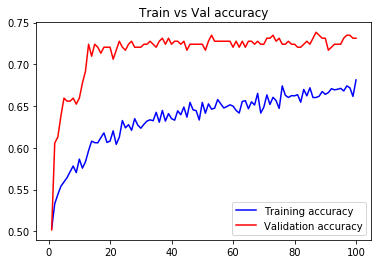

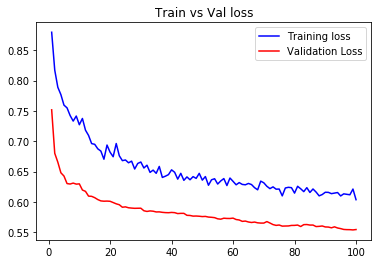

<Figure size 432x288 with 0 Axes>

In [2]:
  
def nin_cnn(input_shape) :
    weight_decay = 1e-4
    model = models.Sequential()
    model.add(layers.Conv2D(8, (2, 2),kernel_initializer='he_uniform' ,kernel_regularizer=regularizers.l2(weight_decay),padding='same',
                            input_shape=X_train.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(8, (2, 2),kernel_initializer='he_uniform' , kernel_regularizer=regularizers.l2(weight_decay), 
                            padding='same'))
    model.add(layers.Activation('elu'))

    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(8, (2, 2),kernel_initializer='he_uniform' , kernel_regularizer=regularizers.l2(weight_decay), 
                            padding='same'))
    model.add(layers.Activation('elu'))

    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(16, (2, 2),kernel_initializer='he_uniform' , kernel_regularizer=regularizers.l2(weight_decay), 
                        padding='same'))
    model.add(layers.Activation('elu'))

    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(10,kernel_size=[25,25], strides=(1, 1), padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.15))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(1,kernel_size=[1,1], strides=(1, 1), padding='valid'))
    
    model.add(layers.Activation('sigmoid'))
    
    model.add(layers.Flatten())
    print(model.summary())
    
    return model
model = nin_cnn( X_train)

from tensorflow.keras.utils import to_categorical
from keras import backend
from math import pi
from math import cos
from math import floor
class SnapshotEnsemble1(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    # calculate learning rate for epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs={}):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

    # save models at the end of each cycle
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = floor(self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "fullycnn_snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

n_epochs = 100
n_cycles = n_epochs / 10

ca = SnapshotEnsemble1(n_epochs, n_cycles, 0.001)

model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.005, momentum=0.07, nesterov=False), metrics=['acc'])
"""optimizers.SGD(lr=0.0025, momentum=1e-4, nesterov=False), metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['acc'])"""
es_callback = callbacks.EarlyStopping(monitor='val_acc', patience=5)

#train_datagen.fit(X_train)
#train_generator= train_datagen.flow(X_train, Y_train, batch_size=batch_size,shuffle=True)
"""
augmented_images = [train_generator[0][0][0] for i in range(5)]

plotImages(augmented_images)


val_generator= val_datagen.flow(X_val, Y_val,batch_size=batch_size,shuffle=True)"""

history= model.fit(#train_generator,
                    X_train,Y_train,
                            batch_size= 32,
                            #steps_per_epoch=trainSize,
                            epochs=100,
                            validation_data=(X_val,Y_val),#val_generator,
                            #validation_steps=valSize,
                            #callbacks=[LearningRateScheduler(lr_schedule)]
                            callbacks=[ca]
                            )


print(history)
model.save_weights('model_weights_cnn(4).h5')
model.save('model_keras_cnn(4).h5')
scores = model.evaluate(X_test, Y_test, verbose=1)
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow(
    X_test, Y_test,
    batch_size=batch_size,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(len(Y_test) / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.where(predictions>0.5, 1, 0)
# Get most likely class
#predicted_classes = np.argmax(predictions, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test,predicted_classes))

"""true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  
"""


acc = history.history['acc']
val_acc= history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range (1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Train vs Val accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train vs Val loss')
plt.legend()
plt.figure()


summed:  [[0.21846092]
 [0.25872737]
 [0.23799065]
 [0.23543015]
 [0.40483326]
 [0.33339792]
 [0.15912843]
 [0.3770435 ]
 [0.34656078]
 [0.72312164]
 [0.3261636 ]
 [0.28118044]
 [0.45908374]
 [0.49138975]
 [0.3998841 ]
 [0.34071743]
 [0.12598813]
 [0.09350505]
 [0.38332814]
 [0.15199041]
 [0.11541316]
 [0.55719584]
 [0.64982086]
 [0.27403963]
 [0.3324298 ]
 [0.61535245]
 [0.26069903]
 [0.56458527]
 [0.71656513]
 [0.0536375 ]
 [0.39763504]
 [0.3264895 ]
 [0.25372112]
 [0.19256762]
 [0.34557086]
 [0.3957634 ]
 [0.46099898]
 [0.26781058]
 [0.26777256]
 [0.3493284 ]
 [0.49191135]
 [0.3232342 ]
 [0.5105326 ]
 [0.5436915 ]
 [0.13394871]
 [0.075941  ]
 [0.19837856]
 [0.19396713]
 [0.1577721 ]
 [0.3486955 ]
 [0.58624524]
 [0.68136406]
 [0.4174568 ]
 [0.6739907 ]
 [0.15717617]
 [0.37314594]
 [0.04820994]
 [0.5174096 ]
 [0.5704829 ]
 [0.3073908 ]
 [0.24100277]
 [0.35226896]
 [0.46442914]
 [0.5598366 ]
 [0.48642617]
 [0.23913616]
 [0.6101699 ]
 [0.45582858]
 [0.40259674]
 [0.62092304]
 [0.793959 

193/193 [==============================] - 0s 233us/sample - loss: 0.5418 - acc: 0.7772
> 3: single=0.777, ensemble=0.782
summed:  [[0.86079836]
 [1.0969552 ]
 [1.0202452 ]
 [0.97604907]
 [1.624142  ]
 [1.3815424 ]
 [0.64600503]
 [1.5528011 ]
 [1.3647574 ]
 [2.9257803 ]
 [1.3357536 ]
 [1.1892323 ]
 [1.9019043 ]
 [1.9386688 ]
 [1.6409807 ]
 [1.5064883 ]
 [0.52534795]
 [0.3858289 ]
 [1.5603912 ]
 [0.6065968 ]
 [0.48798802]
 [2.2286491 ]
 [2.5783257 ]
 [1.0506014 ]
 [1.3746732 ]
 [2.3430972 ]
 [1.108562  ]
 [2.2834985 ]
 [2.811304  ]
 [0.21148163]
 [1.6157451 ]
 [1.2707897 ]
 [1.0506982 ]
 [0.7956853 ]
 [1.4222513 ]
 [1.6063462 ]
 [1.7644508 ]
 [1.054611  ]
 [0.99368024]
 [1.4562638 ]
 [2.0272126 ]
 [1.3862123 ]
 [2.0262418 ]
 [2.1634352 ]
 [0.5184166 ]
 [0.31409317]
 [0.8158889 ]
 [0.81456363]
 [0.6651437 ]
 [1.4357579 ]
 [2.3380048 ]
 [2.6715186 ]
 [1.6749761 ]
 [2.7478733 ]
 [0.62502694]
 [1.4603302 ]
 [0.1965465 ]
 [2.0108817 ]
 [2.259286  ]
 [1.2748313 ]
 [0.9662515 ]
 [1.4537051 ]
 

193/193 [==============================] - 0s 253us/sample - loss: 0.5486 - acc: 0.7513
> 6: single=0.751, ensemble=0.777
summed:  [[1.4877584 ]
 [2.0228992 ]
 [1.9593027 ]
 [1.7773626 ]
 [2.941493  ]
 [2.4691207 ]
 [1.1088597 ]
 [2.8076398 ]
 [2.3343084 ]
 [5.0288224 ]
 [2.4799454 ]
 [2.2113895 ]
 [3.539022  ]
 [3.3744345 ]
 [2.8632157 ]
 [2.9548292 ]
 [0.9736457 ]
 [0.8352115 ]
 [2.8874216 ]
 [1.0902984 ]
 [0.92787784]
 [3.8712165 ]
 [4.506449  ]
 [1.8028532 ]
 [2.5429668 ]
 [4.0508976 ]
 [1.9263461 ]
 [4.0027065 ]
 [4.817306  ]
 [0.36283723]
 [2.9460056 ]
 [2.092828  ]
 [1.9158956 ]
 [1.3509659 ]
 [2.6182022 ]
 [2.938432  ]
 [2.9161115 ]
 [1.9033058 ]
 [1.5829661 ]
 [2.6551616 ]
 [3.6745849 ]
 [2.6587563 ]
 [3.539865  ]
 [3.7549982 ]
 [0.9343749 ]
 [0.5769844 ]
 [1.4237962 ]
 [1.3765492 ]
 [1.2703172 ]
 [2.5864716 ]
 [4.0978847 ]
 [4.5574093 ]
 [2.836956  ]
 [4.806623  ]
 [1.0831095 ]
 [2.5042732 ]
 [0.3476993 ]
 [3.6125293 ]
 [3.9376183 ]
 [2.2405438 ]
 [1.754723  ]
 [2.6408272 ]
 

193/193 [==============================] - 0s 258us/sample - loss: 0.5610 - acc: 0.7047
> 9: single=0.705, ensemble=0.751
summed:  [[2.1792705 ]
 [3.069889  ]
 [3.336719  ]
 [2.7438102 ]
 [4.307478  ]
 [3.6507668 ]
 [1.6173959 ]
 [4.0898986 ]
 [3.1379476 ]
 [6.950482  ]
 [3.9480245 ]
 [3.5148637 ]
 [5.271641  ]
 [4.6673474 ]
 [4.0656915 ]
 [4.764103  ]
 [1.6515124 ]
 [1.608398  ]
 [4.466233  ]
 [1.813399  ]
 [1.5949669 ]
 [5.516307  ]
 [6.454304  ]
 [2.516639  ]
 [4.0797596 ]
 [5.6447964 ]
 [2.820178  ]
 [5.696999  ]
 [6.6538076 ]
 [0.51504207]
 [4.535217  ]
 [2.7455297 ]
 [2.9193466 ]
 [1.9769781 ]
 [4.1497726 ]
 [4.5063577 ]
 [4.011254  ]
 [2.8199883 ]
 [2.2268589 ]
 [3.9742134 ]
 [5.270396  ]
 [4.11599   ]
 [5.1388474 ]
 [5.242448  ]
 [1.4633651 ]
 [0.8769283 ]
 [2.0576932 ]
 [1.9512255 ]
 [2.0754156 ]
 [3.9659028 ]
 [5.8985877 ]
 [6.2536182 ]
 [3.8680785 ]
 [6.842674  ]
 [1.4991758 ]
 [3.5347464 ]
 [0.56318367]
 [5.343356  ]
 [5.674411  ]
 [3.2670677 ]
 [2.712009  ]
 [3.9687848 ]
 

193/193 [==============================] - 0s 248us/sample - loss: 0.5899 - acc: 0.7617
> 12: single=0.762, ensemble=0.756
summed:  [[ 3.5724418]
 [ 3.3300831]
 [ 3.54658  ]
 [ 3.5233796]
 [ 5.6008134]
 [ 3.9531584]
 [ 1.986437 ]
 [ 5.6588154]
 [ 4.483753 ]
 [ 9.491922 ]
 [ 4.8121505]
 [ 3.6785529]
 [ 6.564676 ]
 [ 5.468736 ]
 [ 5.288699 ]
 [ 5.272385 ]
 [ 1.9707719]
 [ 2.142982 ]
 [ 5.4286   ]
 [ 2.0685034]
 [ 1.7068689]
 [ 6.403272 ]
 [ 8.299826 ]
 [ 3.6637702]
 [ 5.772453 ]
 [ 8.339328 ]
 [ 4.0581098]
 [ 7.0337567]
 [ 9.547524 ]
 [ 0.8020148]
 [ 5.905222 ]
 [ 4.960976 ]
 [ 4.633835 ]
 [ 2.896161 ]
 [ 4.7213354]
 [ 5.9450436]
 [ 6.59875  ]
 [ 3.4746134]
 [ 2.6205797]
 [ 5.2315555]
 [ 6.75597  ]
 [ 4.871775 ]
 [ 5.634137 ]
 [ 7.382794 ]
 [ 2.3747244]
 [ 1.724784 ]
 [ 2.641464 ]
 [ 3.0916293]
 [ 2.37056  ]
 [ 5.190314 ]
 [ 8.20793  ]
 [ 7.859124 ]
 [ 4.971852 ]
 [ 8.489711 ]
 [ 2.4465716]
 [ 5.405221 ]
 [ 1.2202241]
 [ 6.072311 ]
 [ 8.248249 ]
 [ 4.554306 ]
 [ 3.774778 ]
 [ 5.6595216]


193/193 [==============================] - 0s 238us/sample - loss: 0.5858 - acc: 0.7306
> 15: single=0.731, ensemble=0.762
summed:  [[ 5.1549244 ]
 [ 3.8346665 ]
 [ 3.8532743 ]
 [ 4.2765284 ]
 [ 7.0249047 ]
 [ 4.3358555 ]
 [ 2.4154372 ]
 [ 6.7793803 ]
 [ 5.7957296 ]
 [11.741504  ]
 [ 5.762866  ]
 [ 3.9213796 ]
 [ 8.249839  ]
 [ 6.8015804 ]
 [ 6.5795426 ]
 [ 5.901305  ]
 [ 2.2392344 ]
 [ 2.498949  ]
 [ 6.5047646 ]
 [ 2.3528783 ]
 [ 1.8332818 ]
 [ 7.5406456 ]
 [10.305236  ]
 [ 4.711778  ]
 [ 6.89901   ]
 [10.747966  ]
 [ 5.2793465 ]
 [ 8.443281  ]
 [12.3273535 ]
 [ 1.061948  ]
 [ 7.555168  ]
 [ 6.9926715 ]
 [ 6.5851517 ]
 [ 4.115991  ]
 [ 5.471758  ]
 [ 7.2931347 ]
 [ 9.19628   ]
 [ 4.0641246 ]
 [ 3.2367258 ]
 [ 6.395897  ]
 [ 8.208021  ]
 [ 5.736574  ]
 [ 6.2183475 ]
 [ 9.615341  ]
 [ 3.2533386 ]
 [ 2.563526  ]
 [ 3.2678516 ]
 [ 4.6566653 ]
 [ 2.658664  ]
 [ 6.652225  ]
 [10.434434  ]
 [ 9.804312  ]
 [ 6.2577176 ]
 [10.052689  ]
 [ 3.2530844 ]
 [ 7.188368  ]
 [ 1.7637674 ]
 [ 7.041745  

193/193 [==============================] - 0s 258us/sample - loss: 0.5511 - acc: 0.7358
> 18: single=0.736, ensemble=0.767
summed:  [[ 6.354894 ]
 [ 4.46987  ]
 [ 4.3164535]
 [ 4.937266 ]
 [ 8.720552 ]
 [ 4.9510226]
 [ 3.0093744]
 [ 7.7144523]
 [ 7.14943  ]
 [13.8251   ]
 [ 6.905626 ]
 [ 4.392059 ]
 [10.291271 ]
 [ 8.454976 ]
 [ 7.8596973]
 [ 6.897095 ]
 [ 2.5725374]
 [ 2.8175926]
 [ 7.799855 ]
 [ 2.6284204]
 [ 1.9971746]
 [ 8.780652 ]
 [12.177136 ]
 [ 5.9276295]
 [ 7.8766236]
 [12.597799 ]
 [ 6.5575733]
 [10.006838 ]
 [14.816464 ]
 [ 1.2479863]
 [ 9.058519 ]
 [ 8.526265 ]
 [ 8.358671 ]
 [ 5.267664 ]
 [ 6.3557186]
 [ 8.478492 ]
 [11.417029 ]
 [ 4.843636 ]
 [ 3.9041145]
 [ 7.575588 ]
 [ 9.666518 ]
 [ 6.99175  ]
 [ 7.113607 ]
 [11.862457 ]
 [ 4.1450977]
 [ 3.4142134]
 [ 3.9339244]
 [ 6.1793404]
 [ 3.0160575]
 [ 8.094669 ]
 [12.273555 ]
 [11.778446 ]
 [ 7.629    ]
 [11.878401 ]
 [ 3.9915383]
 [ 9.102359 ]
 [ 2.1178675]
 [ 8.171535 ]
 [12.849066 ]
 [ 6.363924 ]
 [ 5.8699183]
 [ 8.539237 ]


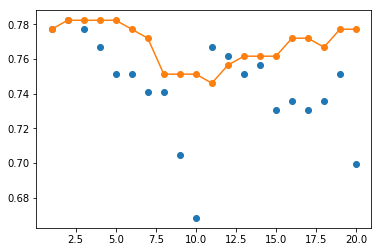

In [54]:
#Model Average
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
# load models from file
def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
"""members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
members = list(reversed(members))"""
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    numbers= len(members)
    yhats = [model.predict(testX) for model in members]
    yhats= np.array(yhats)
    
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    print("summed: ",summed)
    average = lambda x: x / numbers 
    summed = average(summed)
    result=numpy.argmax(summed, axis=1)
    # argmax across classes
    #result = np.where(summed>0.5, 1, 0)
    print(result)
    return result
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)



single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test, Y_test)
    # evaluate the i'th model standalone
    #testy_enc = to_categorical(Y_test)
    _, single_score = members[i-1].evaluate(X_test, Y_test, verbose=1)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
print('Ensemble Accuracy %.3f (%.3f)' % (mean(ensemble_scores), std(ensemble_scores)))

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

193/193 [==============================] - 0s 424us/sample - loss: 0.5539 - acc: 0.7824
> 1: single=0.782, ensemble=0.782
193/193 [==============================] - 0s 372us/sample - loss: 0.5539 - acc: 0.8083
> 2: single=0.808, ensemble=0.808
193/193 [==============================] - 0s 403us/sample - loss: 0.5596 - acc: 0.7979
> 3: single=0.798, ensemble=0.808
193/193 [==============================] - 0s 429us/sample - loss: 0.5755 - acc: 0.7513
> 4: single=0.751, ensemble=0.798
193/193 [==============================] - 0s 419us/sample - loss: 0.5862 - acc: 0.7461
> 5: single=0.746, ensemble=0.798
193/193 [==============================] - 0s 398us/sample - loss: 0.6117 - acc: 0.7047
> 6: single=0.705, ensemble=0.762
193/193 [==============================] - 0s 434us/sample - loss: 0.6124 - acc: 0.7150
> 7: single=0.715, ensemble=0.756
193/193 [==============================] - 0s 424us/sample - loss: 0.6295 - acc: 0.6943
> 8: single=0.694, ensemble=0.751
193/193 [===============

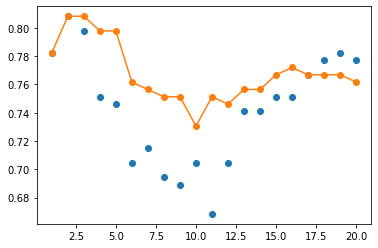

In [29]:
#Weighted Average
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
# load models from file
def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
"""members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
members = list(reversed(members))"""
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    numbers= len(members)
    yhats = [model.predict(testX) for model in members]
    yhats= np.array(yhats)
    yhats=np.where(yhats>0.5, 1, 0)
    
    
    
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    #print("summed: ",summed)
    """ average = lambda x: x / numbers 
    summed = average(summed)
    temp=numpy.argmax(summed, axis=1)"""
    result= np.where(summed >= numbers/2, 1, 0)
    #print("summed after:",result)
    # argmax across classes
    #result = np.where(summed>0.5, 1, 0)
    #print(result)
    return result
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)



single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test, Y_test)
    # evaluate the i'th model standalone
    #testy_enc = to_categorical(Y_test)
    _, single_score = members[i-1].evaluate(X_test, Y_test, verbose=1)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
print('Ensemble Accuracy %.3f (%.3f)' % (mean(ensemble_scores), std(ensemble_scores)))

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

model 1: accuracy = 0.7772
model 2: accuracy = 0.7824
model 3: accuracy = 0.7772
model 4: accuracy = 0.7668
model 5: accuracy = 0.7513
model 6: accuracy = 0.7513
model 7: accuracy = 0.7409
model 8: accuracy = 0.7409
model 9: accuracy = 0.7047
model 10: accuracy = 0.6684
model 11: accuracy = 0.7668
model 12: accuracy = 0.7617
model 13: accuracy = 0.7513
model 14: accuracy = 0.7565
model 15: accuracy = 0.7306
model 16: accuracy = 0.7358
model 17: accuracy = 0.7306
model 18: accuracy = 0.7358
model 19: accuracy = 0.7513
model 20: accuracy = 0.6995
ensemble: accuracy = 0.7772
“Normalized confusion matrix”
0.7401266766020864


"plt.figure(1)\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))\n#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nplt.title('ROC curve')\nplt.legend(loc='best')\nplt.show()\n"

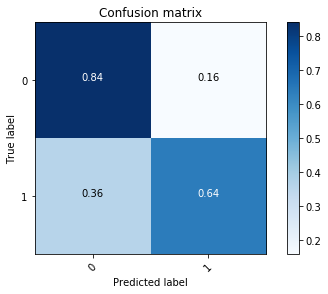

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
# load models from file
def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
# makes prediction according to given models and given weights
def predict(models, data, weights=None):
    if weights is None:
        # default weights provide voting equality
        weights = [1 / (len(models))] * len(models)
    pred = np.zeros((data.shape[0], 1))
    for i, model in enumerate(models):
        pred += model.predict(data) * weights[i]
    return pred
    
# returns accuracy for given predictions
def evaluate(preds, weights=None):
    if weights is None:
        weights = [1 / len(preds)] * len(preds)
    y_pred = np.zeros((Y_test.shape[0], 1))
    
    for i, pred in enumerate(preds):
        y_pred += pred * weights[i]
    
    y_true=np.where(y_pred>0.5, 1, 0)
    #print(y_true)
    y_pred = np.argmax(y_pred, axis=0)
    #print(y_pred)
    #y_true = np.argmax(Y_test, axis=0)
    #print(y_pred,y_true)
    return accuracy_score(Y_test, y_true)

# load list of snapshots
"""members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
models = list(reversed(members))"""
# precalculated predictions of all models
preds = []
# evaluate every model as single
for i, model in enumerate(models):
    pred = predict([model], X_test)
    preds.append(pred)
    score = evaluate([pred])
    print(f'model {i + 1}: accuracy = {score:.4f}')

# evaluate ensemble (with voting equality)
ensemble_score = evaluate(preds)
print(f'ensemble: accuracy = {ensemble_score:.4f}')

def predicted(preds, weights=None):
    if weights is None:
        weights = [1 / len(preds)] * len(preds)
    y_pred = np.zeros((Y_test.shape[0], 1))
    
    for i, pred in enumerate(preds):
        y_pred += pred * weights[i]
    
    y_true=np.where(y_pred>0.5, 1, 0)
    return y_true


y_preds1 = predicted(preds)
plot_confusion_matrix(confusion_matrix(Y_test,y_preds1), seriousness,normalize=True)

y_pred_keras = predicted(preds)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

#auc_rf = auc(fpr_rf, tpr_rf)

"""plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
"""


shape: (4461, 1, 20)
estimators 200 (4461, 20)
shape: (279, 1, 20)
estimators 200 (279, 20)
(279, 25, 25, 3) (279,)
No of random features: 20
Classes importance: 2
feature importances: [0.02382051 0.02806295 0.03889072 0.0420998  0.04570452 0.08232046
 0.08151356 0.12698448 0.14385825 0.21524394 0.0187546  0.01962372
 0.01748826 0.01678286 0.01595691 0.01490105 0.01690214 0.01590655
 0.01626466 0.01892007]
oob score: 0.8847791974893522 0.8494623655913979
shape: (193, 1, 20)
val score model: 0.6735751295336787
shape: (193, 1, 20)
[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0
 1 0 1 1 0 0 1 0]
Stacked Test Accuracy: 0.653
Accuracy nan (nan)


C:\Users\shris\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shris\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\shris\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\shris\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\shris\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shape: (193, 1, 20)
12:::! [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0
 1 0 1 1 0 0 1 0]
!:::! [[0.87  0.13 ]
 [0.955 0.045]
 [0.985 0.015]
 [1.    0.   ]
 [0.945 0.055]
 [0.935 0.065]
 [0.975 0.025]
 [0.01  0.99 ]
 [0.81  0.19 ]
 [0.01  0.99 ]
 [0.895 0.105]
 [0.945 0.055]
 [0.8   0.2  ]
 [0.925 0.075]
 [0.895 0.105]
 [0.66  0.34 ]
 [0.435 0.565]
 [0.935 0.065]
 [0.825 0.175]
 [0.85  0.15 ]
 [0.955 0.045]
 [0.29  0.71 ]
 [0.055 0.945]
 [0.59  0.41 ]
 [0.205 0.795]
 [0.05  0.95 ]
 [0.995 0.005]
 [0.955 0.045]
 [0.    1.   ]
 [0.975 0.025]
 [0.1   0.9  ]
 [0.21  0.79 ]
 [0.995 0.005]
 [0.74  0.26 ]
 [0.845 0.155]
 [0.715 0.285]
 [0.325 0.675]
 [1.    0.   ]
 [0.

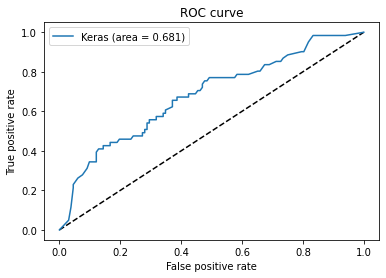

Confusion Matrix
[[93 39]
 [28 33]]
“Normalized confusion matrix”


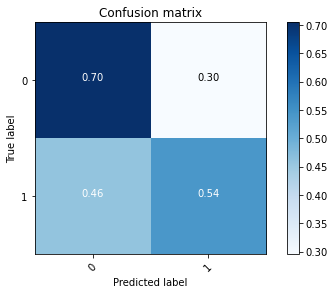

In [10]:

# stacked generalization with linear meta model on blobs dataset
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Average,Maximum, Minimum,Input
from tensorflow.keras.models import Model
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from numpy import dstack
from sklearn.multiclass import OneVsRestClassifier
# load models from file
def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
"""members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
models = list(reversed(members))"""
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    print("shape:",stackX.shape)
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    RANDOM_SEED= 42
    clf2 = RandomForestClassifier(n_estimators=200,random_state=RANDOM_SEED,oob_score=True)
    print("estimators",clf2.n_estimators,stackedX.shape)

    """sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)"""


    # Learn to predict each class against the other
    clf = clf2.fit(stackedX, inputy)

    #model = LogisticRegression()
    """model1= svm.SVC"""
    #model.fit(stackedX, inputy)
    return clf
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    
    yhat = model.predict(stackedX)
    return yhat

def stacked_prediction_prob(members, model, inputX,a):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    print("12:::!",yhat)
    #t1= model.predict_proba(stackedX)
    a= model.predict_proba(stackedX)
    #temp=model.decision_function(stackedX)
    print("!:::!",a)
    return a[:,1]
    
single_scores, ensemble_scores = list(), list()
"""for i in range(1, len(members)+1):
    
    _, single_score = members[i-1].evaluate(X_test, Y_test, verbose=1)
    # summarize this step
    print('> %d: single=%.3f,' % (i, single_score))
    single_scores.append(single_score)"""
model = fit_stacked_model(members, X_train, Y_train)
model1= fit_stacked_model(members, X_val, Y_val)
print(X_val.shape, Y_val.shape)
print("No of random features:",model.n_features_)
print("Classes importance:",model.n_classes_)
print("feature importances:", model.feature_importances_)
#print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_test, Y_test),model.oob_score_, model.score(X_val, y_val)))
print("oob score:",model.oob_score_, model1.oob_score_)
yhat1 = stacked_prediction(members, model1, X_test)
print("val score model:",accuracy_score(Y_test, yhat1))

from sklearn import metrics
pred_train = np.argmax(model.oob_decision_function_,axis=1)

#print(metrics.roc_auc_score(Y_test, pred_train))

# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
print(yhat)
acc = accuracy_score(Y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)    
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
#----------------------------------------------------------------------------------------------------------------
# plot AUC
single_scores, ensemble_scores = list(), list()

y_pred_keras= stacked_prediction_prob(members, model, X_test,"")
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#-------------------------------------------------------------------------------------------------------------------
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    
    
 
    #Add Normalization Option
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("“Normalized confusion matrix”")
    else:
        print("‘Confusion matrix, without normalization’")
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

    
preds_list= np.round(yhat,0)
"""flat_list = [item for sublist in preds for item in sublist]
ctBenign=0
ctMalign=0
preds_list=list(map(lambda x: int(x), flat_list))"""

preds=np.array(preds_list)

seriousness= [0,1]

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test,preds))

plot_confusion_matrix(confusion_matrix(Y_test,preds), seriousness,normalize=True)

In [4]:
# Weighted average

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Average,Maximum, Minimum,Input
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
"""def load_all_models(n_models, a):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        if a=='dense':
            filename = 'fullyDense_snapshot_model_' + str(i + 1) + '.h5'
        else:
            filename = 'fullycnn_snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
members1= load_all_models(10,'dense')
members2= load_all_models(10,'cnn')
members= members1+members2
print(len(members))
models = list(reversed(members))"""


def ensemble_predictions(members, testX):
    # make predictions
    numbers= len(members)
    yhats = [model.predict(testX) for model in members]
    yhats= np.array(yhats)
    print(yhats.shape)
    #yhats=np.where(yhats>0.5, 1, 0)
    reshaped=np.transpose(yhats)[0]
    print(reshaped)
    print(reshaped.shape)
    
    print("before:",np.sum(yhats[0], axis=0))
    print("After1:",np.sum(reshaped,axis=0)[0])
    
    final=[]
    for i in range(len(reshaped)):
        lesser=[]
        greater=[]
        for j in reshaped[i]:
            if j<0.5:
                lesser.append(j)
            else:
                greater.append(j)
        if (len(greater)>len(lesser)):
            final.append(sum(greater)/len(greater))
        else:
            final.append(sum(lesser)/len(lesser))
    finalarray=np.array(final)
    print("finalArray:",finalarray)
    print(finalarray.shape)
            
    
            
    
    # sum across ensemble members
    summed=np.zeros((193,1))
    for i in range(len(yhats)):
        summed=np.maximum(summed,yhats[i])
        
    #summed = numpy.maximum(yhats)
    print("summed: ",summed)
    #result= np.where(summed >= numbers/2, 1, 0)
    return finalarray

def yhat(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return yhat

single_scores, ensemble_scores = list(), list()

y_pred_keras= yhat(members, len(members),X_val,Y_val).ravel()

print(y_pred_keras)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

#auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#-------------------------------------------------------------------------------------------------------------------
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    
    
 
    #Add Normalization Option
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("“Normalized confusion matrix”")
    else:
        print("‘Confusion matrix, without normalization’")
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

    
preds_list= np.round(y_pred_keras,0)
"""flat_list = [item for sublist in preds for item in sublist]
ctBenign=0
ctMalign=0
preds_list=list(map(lambda x: int(x), flat_list))"""

preds=np.array(preds_list)

seriousness= [0,1]

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test,preds))

plot_confusion_matrix(confusion_matrix(Y_test,preds), seriousness,normalize=True)



ValueError: Error when checking input: expected conv2d_37_input to have 4 dimensions, but got array with shape (279, 1)

In [1]:
# Model Averaging
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Average,Maximum, Minimum,Input
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

def ensemble_predictions(members, testX):
    # make predictions
    numbers= len(members)
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    print("yhats:",yhats, yhats.shape)
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    print(summed.shape)
    average = lambda x: x / numbers 
    summed = average(summed)
    print("summed:",summed)
    # argmax across classes
    
    return summed

def yhat(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return yhat

single_scores, ensemble_scores = list(), list()

y_pred_keras= yhat(members, len(members),X_val,Y_test).ravel()
"""print(y_pred_keras)"""

"""model = load_model('model_keras_fullyconnected(4).h5')

scores = model.evaluate(X_test, Y_test, verbose=1)
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_pred_keras = model.predict(X_test).ravel()"""
print(y_pred_keras)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

#auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#-------------------------------------------------------------------------------------------------------------------
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    
    
 
    #Add Normalization Option
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("“Normalized confusion matrix”")
    else:
        print("‘Confusion matrix, without normalization’")
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

    
preds_list= np.round(y_pred_keras,0)
"""flat_list = [item for sublist in preds for item in sublist]
ctBenign=0
ctMalign=0
preds_list=list(map(lambda x: int(x), flat_list))"""

preds=np.array(preds_list)

seriousness= [0,1]

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test,preds))

plot_confusion_matrix(confusion_matrix(Y_test,preds), seriousness,normalize=True)



E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

NameError: name 'members' is not defined

Confusion Matrix
[[114  18]
 [ 25  36]]
“Normalized confusion matrix”


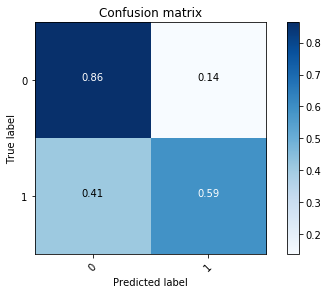

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    
    
 
    #Add Normalization Option
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("“Normalized confusion matrix”")
    else:
        print("‘Confusion matrix, without normalization’")
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

loaded_model = load_model('model_keras_cnn(4).h5')    
preds= np.round(loaded_model.predict(X_test),0)
flat_list = [item for sublist in preds for item in sublist]
ctBenign=0
ctMalign=0
preds_list=list(map(lambda x: int(x), flat_list))

preds=np.array(preds_list)

seriousness= [0,1]

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test,preds))

plot_confusion_matrix(confusion_matrix(Y_test,preds), seriousness,normalize=True)